# <center> Getting Started With The FARS Dataset </center>

# The Accident Table

This table contains general data for each fatal accident.  This data contains a unique identifier, 'ID' and things like geographical location, time, and weather.

### The Person Table

This table contains data about the people involved in the accident.  This includes demographic data and time of death.  The 'ID' columns matches people to accidents.

### The Vehicle Table

Information about the vehicles involved in the accident, such as the make, model, and year of the vehicle.  The 'ID' column matches vehicles to accidents.

In [1]:
# Import libraries and data.
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

acc_df = pd.read_csv('./train/accident_train.csv')
test_df = pd.read_csv('./test/accident_test.csv')
per_df = pd.read_csv('./train/person_train.csv')
veh_df = pd.read_csv('./train/vehicle_train.csv')

acc_df.fillna(-1, inplace=True)
per_df.fillna(-1, inplace=True)
veh_df.fillna(-1, inplace=True)

/Library/Python/2.7/site-packages/pandas/io/parsers.py:1070: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [2]:
# day_week is from acc
# find intersection of columns and take all but ID out for merging
dupe_col = [col for col in per_df.columns
            if col in acc_df.columns and col not in pd.Index(['ID'])]
cols_to_use = per_df.columns - dupe_col
acc_per_df = pd.merge(acc_df, per_df[cols_to_use], on='ID')

In [3]:
# hour+day plotter
acc_per_df[(acc_per_df.DAY_WEEK < 9) & (acc_per_df.HOUR > 26)].head()
# ^above shows that sometimes DAY_WEEK is known but HOUR is, and vice-versa
# these are few, so cut them out
acc_per_df = acc_per_df[(acc_per_df.DAY_WEEK < 9) & (acc_per_df.HOUR < 26)]
# check
acc_per_df[(acc_per_df.DAY_WEEK < 9) & (acc_per_df.HOUR > 26)].head()

# make labels
day_week_labels = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']
day_week_hr_labels = [day_week_labels[day] + '-' + str(hour)
                      for day in range(0,7)
                      for hour in range(0,25)]
day_week_hr_labels
acc_per_df['DAY_WEEK-HOUR'] = acc_per_df['DAY_WEEK']*25 + acc_per_df['HOUR']

suppress output


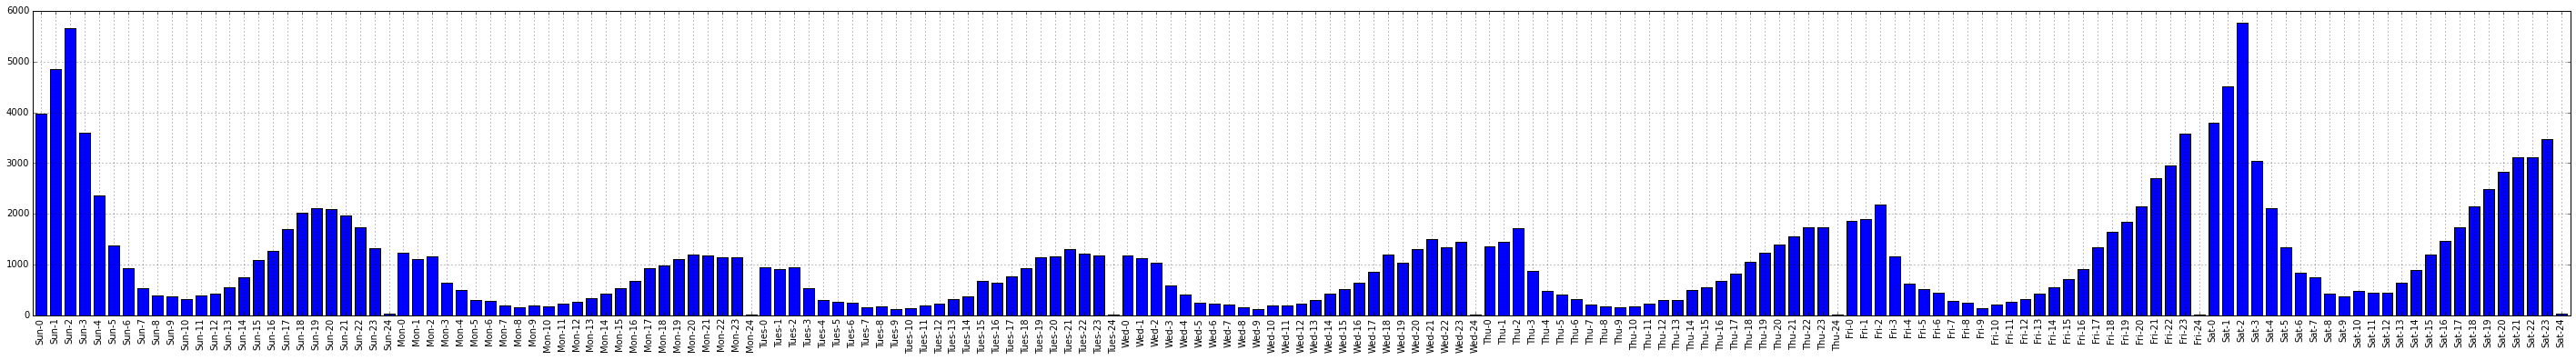

In [4]:
fig = plt.figure()
fig.set_size_inches(50,6)
fig.add_subplot(111)

ax_day_week_hr = acc_per_df[acc_per_df.DRUNK_DR == True]['DAY_WEEK-HOUR'].value_counts().sort_index().plot(kind='bar')
ax_day_week_hr.set_xticklabels(day_week_hr_labels)
print('suppress output')
# Wednesday 3am peak for ddr- bars get out ~2am, so ddr by 3am?

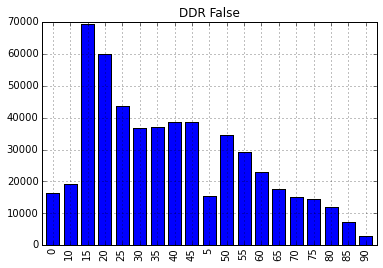

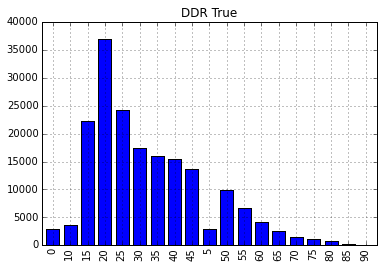

In [5]:
# making (just the) day+hour plotter for:
# what times of the day are different aged drivers crashing?

age_fives_labels = [str(five) for five in range(0,95,5)]
acc_per_df['AGE'].dtype

# cut out unknown 99s by going to 97
acc_per_df['AGE_GROUP'] = pd.cut(acc_per_df.AGE, range(0, 95, 5) + [98], right=False, labels=age_fives_labels)
acc_per_df['AGE_GROUP'].dtype
acc_per_df[acc_per_df.DRUNK_DR == False]['AGE_GROUP'].value_counts().sort_index().plot(kind='bar')
plt.title('DDR False', fontsize=12)
plt.show()
acc_per_df[acc_per_df.DRUNK_DR == True]['AGE_GROUP'].value_counts().sort_index().plot(kind='bar')
plt.title('DDR True', fontsize=12)
plt.show()

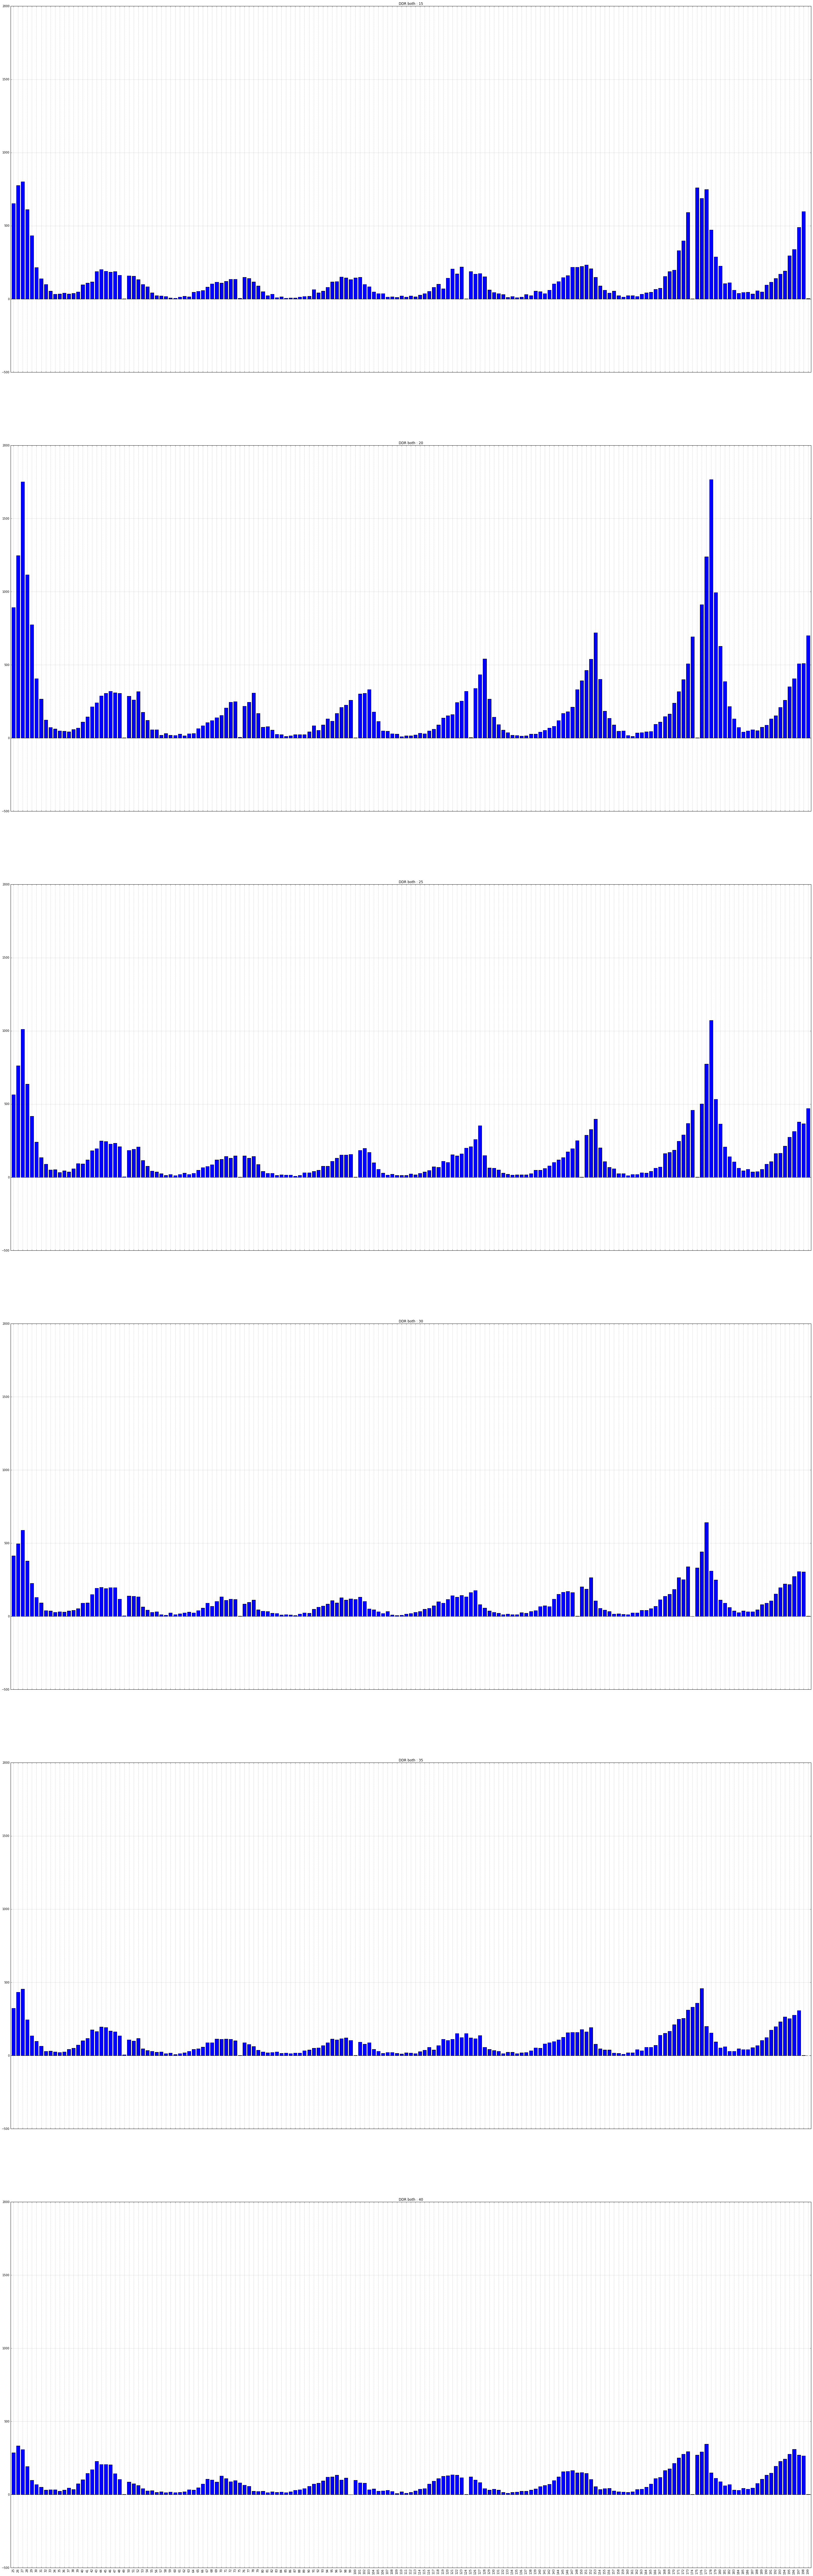

In [11]:
# what times of the day are different aged drivers crashing?

interesting_charts = slice(3, 9)
fig, axs = plt.subplots(len(age_fives_labels[interesting_charts]), 1, sharex=True, sharey=True)

for i, age_group in enumerate(age_fives_labels[interesting_charts]):
    # enum starts from 0 index
    fig.set_size_inches(50,8*20)
    acc_per_df[(acc_per_df.DRUNK_DR == True) & (acc_per_df.AGE_GROUP == age_group)]['DAY_WEEK-HOUR'].value_counts().sort_index().plot(kind='bar',ax=axs[i],title='DDR both : ' + age_group)
plt.show()


# acc_per_df[(acc_per_df.AGE_GROUP == '20')]['DAY_WEEK-HOUR'].value_counts().sort_index().plot(kind='bar')
# daywks = list(daywk_group.groups.keys())
# fatals = np.zeros(len(daywks))
# for i, daywk in enumerate(daywks):
#     fatals[i] = acc_df.ix[daywk_group.groups[daywk]][(acc_df.DRUNK_DR == True)]['FATALS'].sum()
#

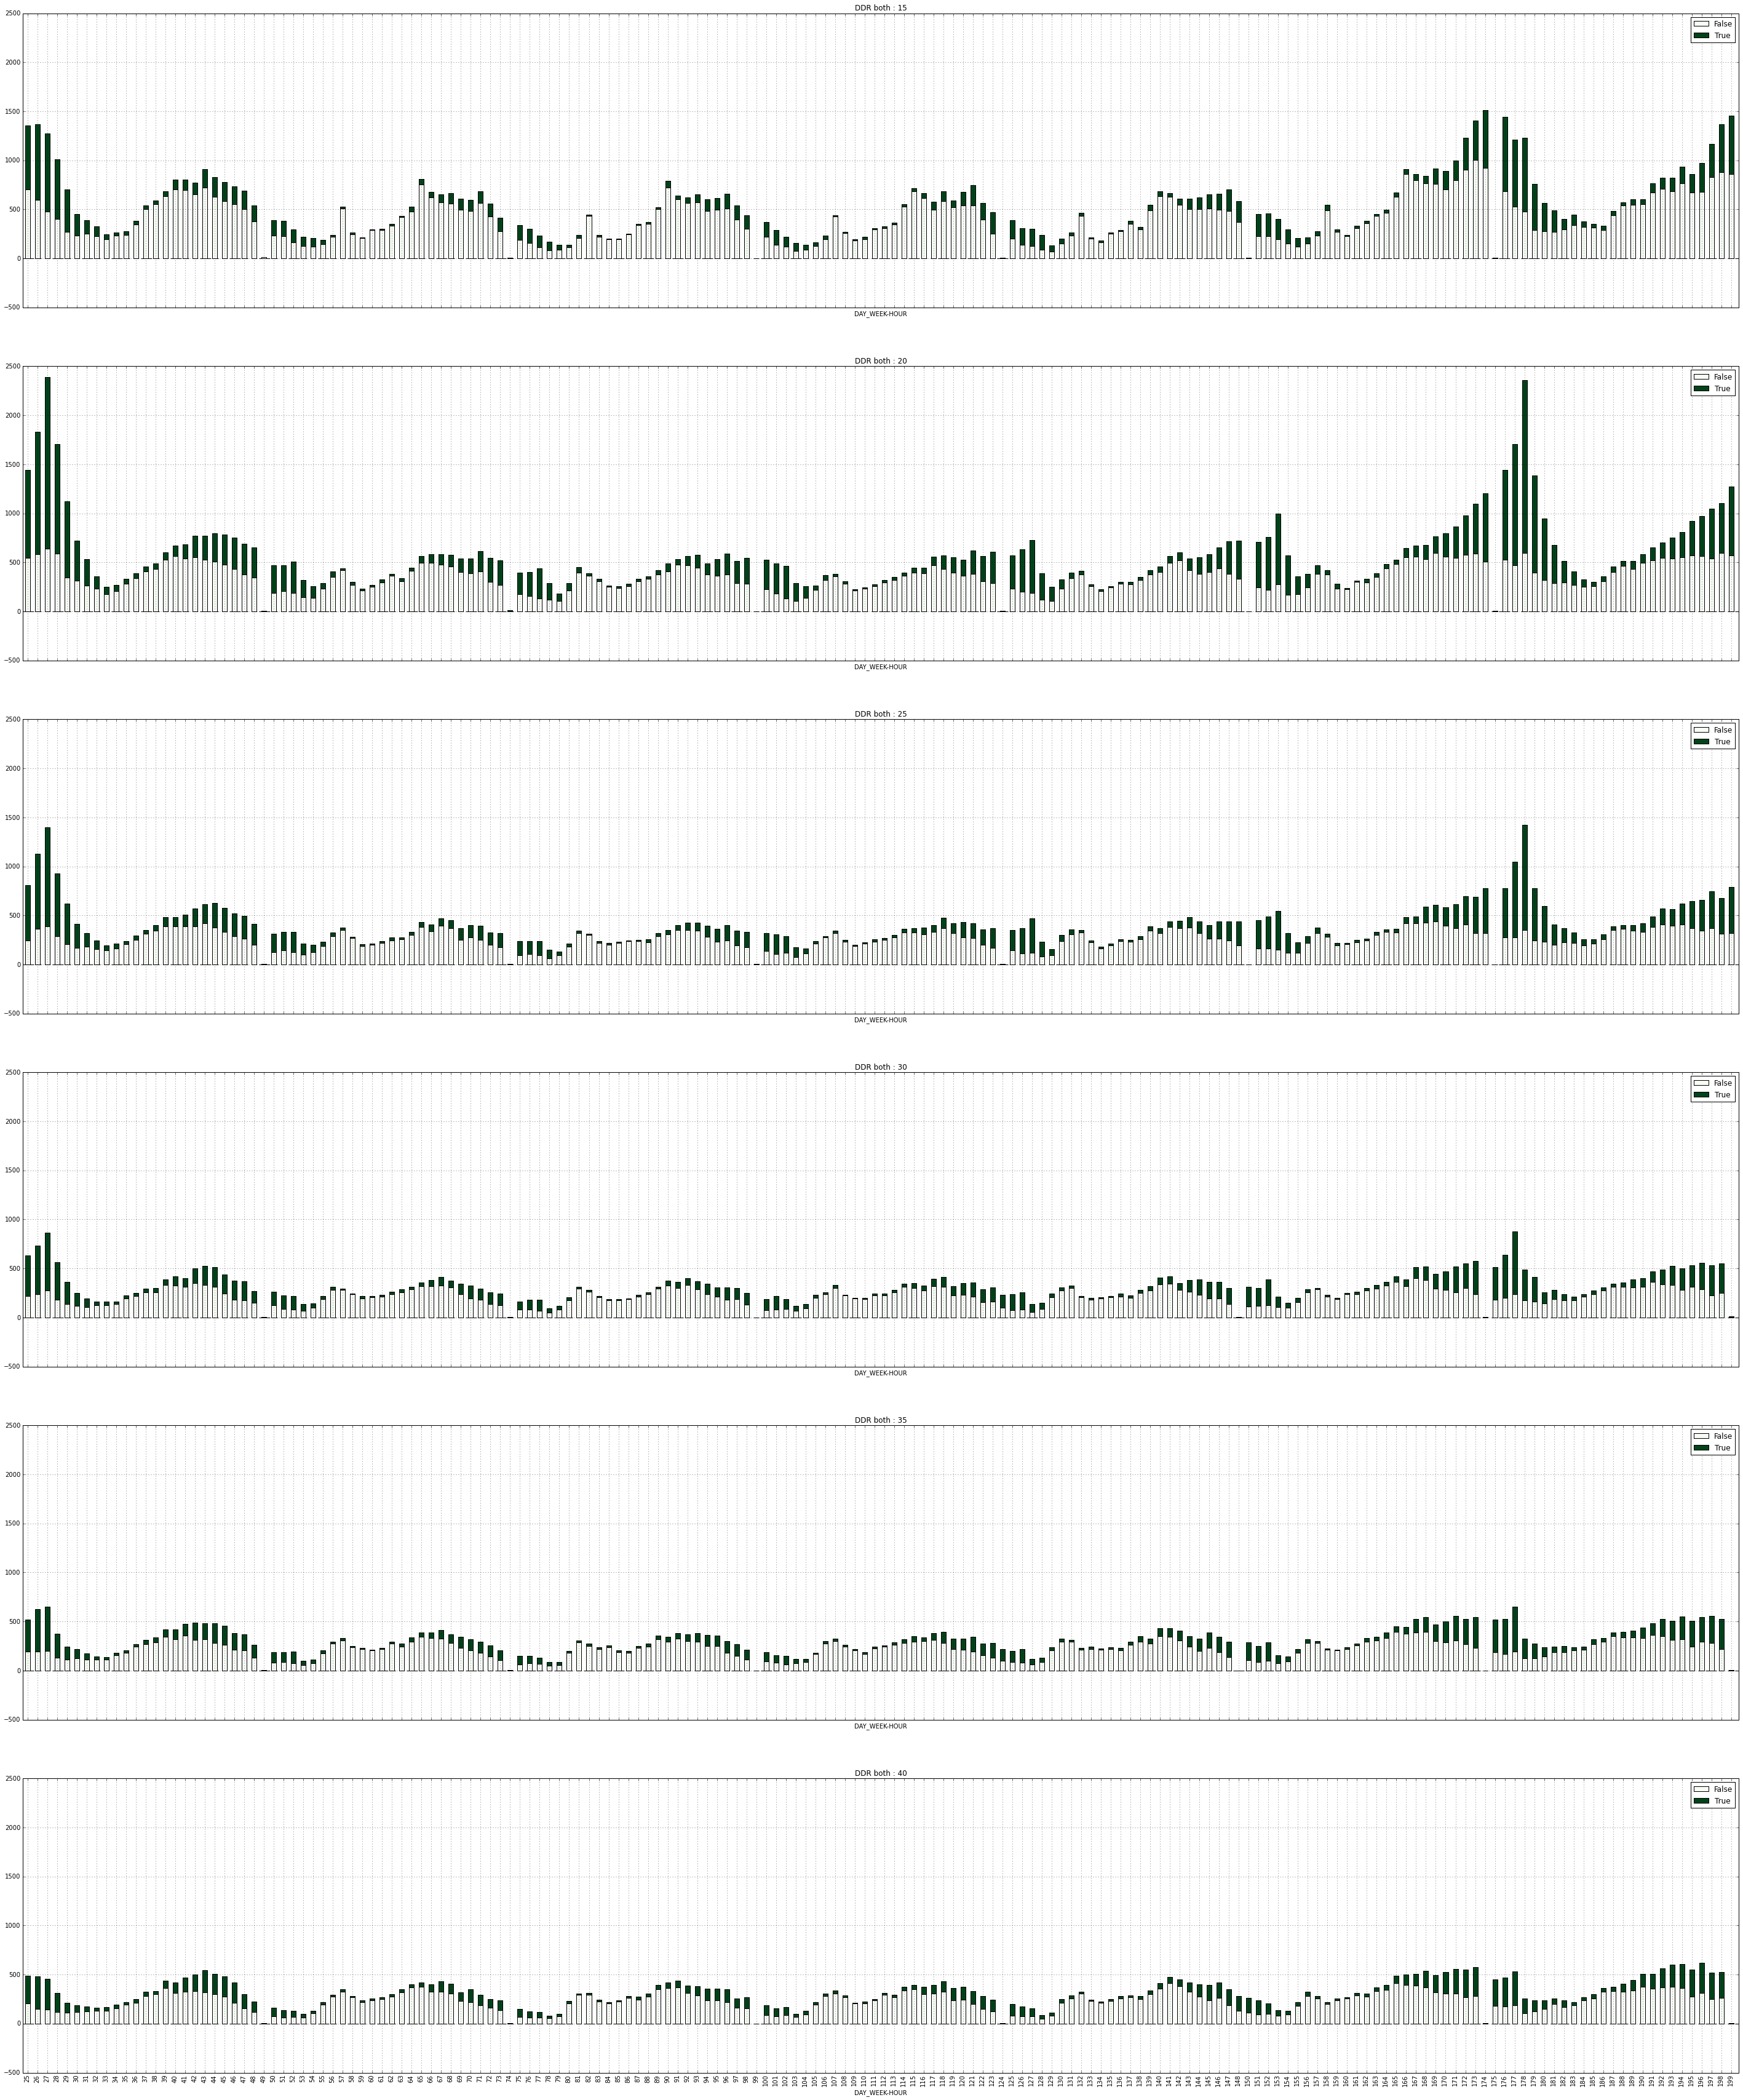

In [13]:
# what times of the day are different aged drivers crashing?
# now plot difference - how much is due to DDR?

interesting_charts = slice(3, 9)
n_charts = len(age_fives_labels[interesting_charts])
fig, axs = plt.subplots(n_charts, 1, sharex=True, sharey=True)

for i, age_group in enumerate(age_fives_labels[interesting_charts]):
    fig.set_size_inches(50,n_charts*8)
    test0 = acc_per_df[(acc_per_df.AGE_GROUP == age_group)].groupby(['DAY_WEEK-HOUR', 'DRUNK_DR'])['DAY_WEEK-HOUR'].count().unstack('DRUNK_DR')
    ax0 = test0.plot(kind='bar', ax=axs[i],title='DDR both : ' + age_group,
                     stacked=True, colormap='Greens')
    ax0.legend(loc='upper right')
plt.show()

# maybe it would be easier to see patterns within each group if they were separate

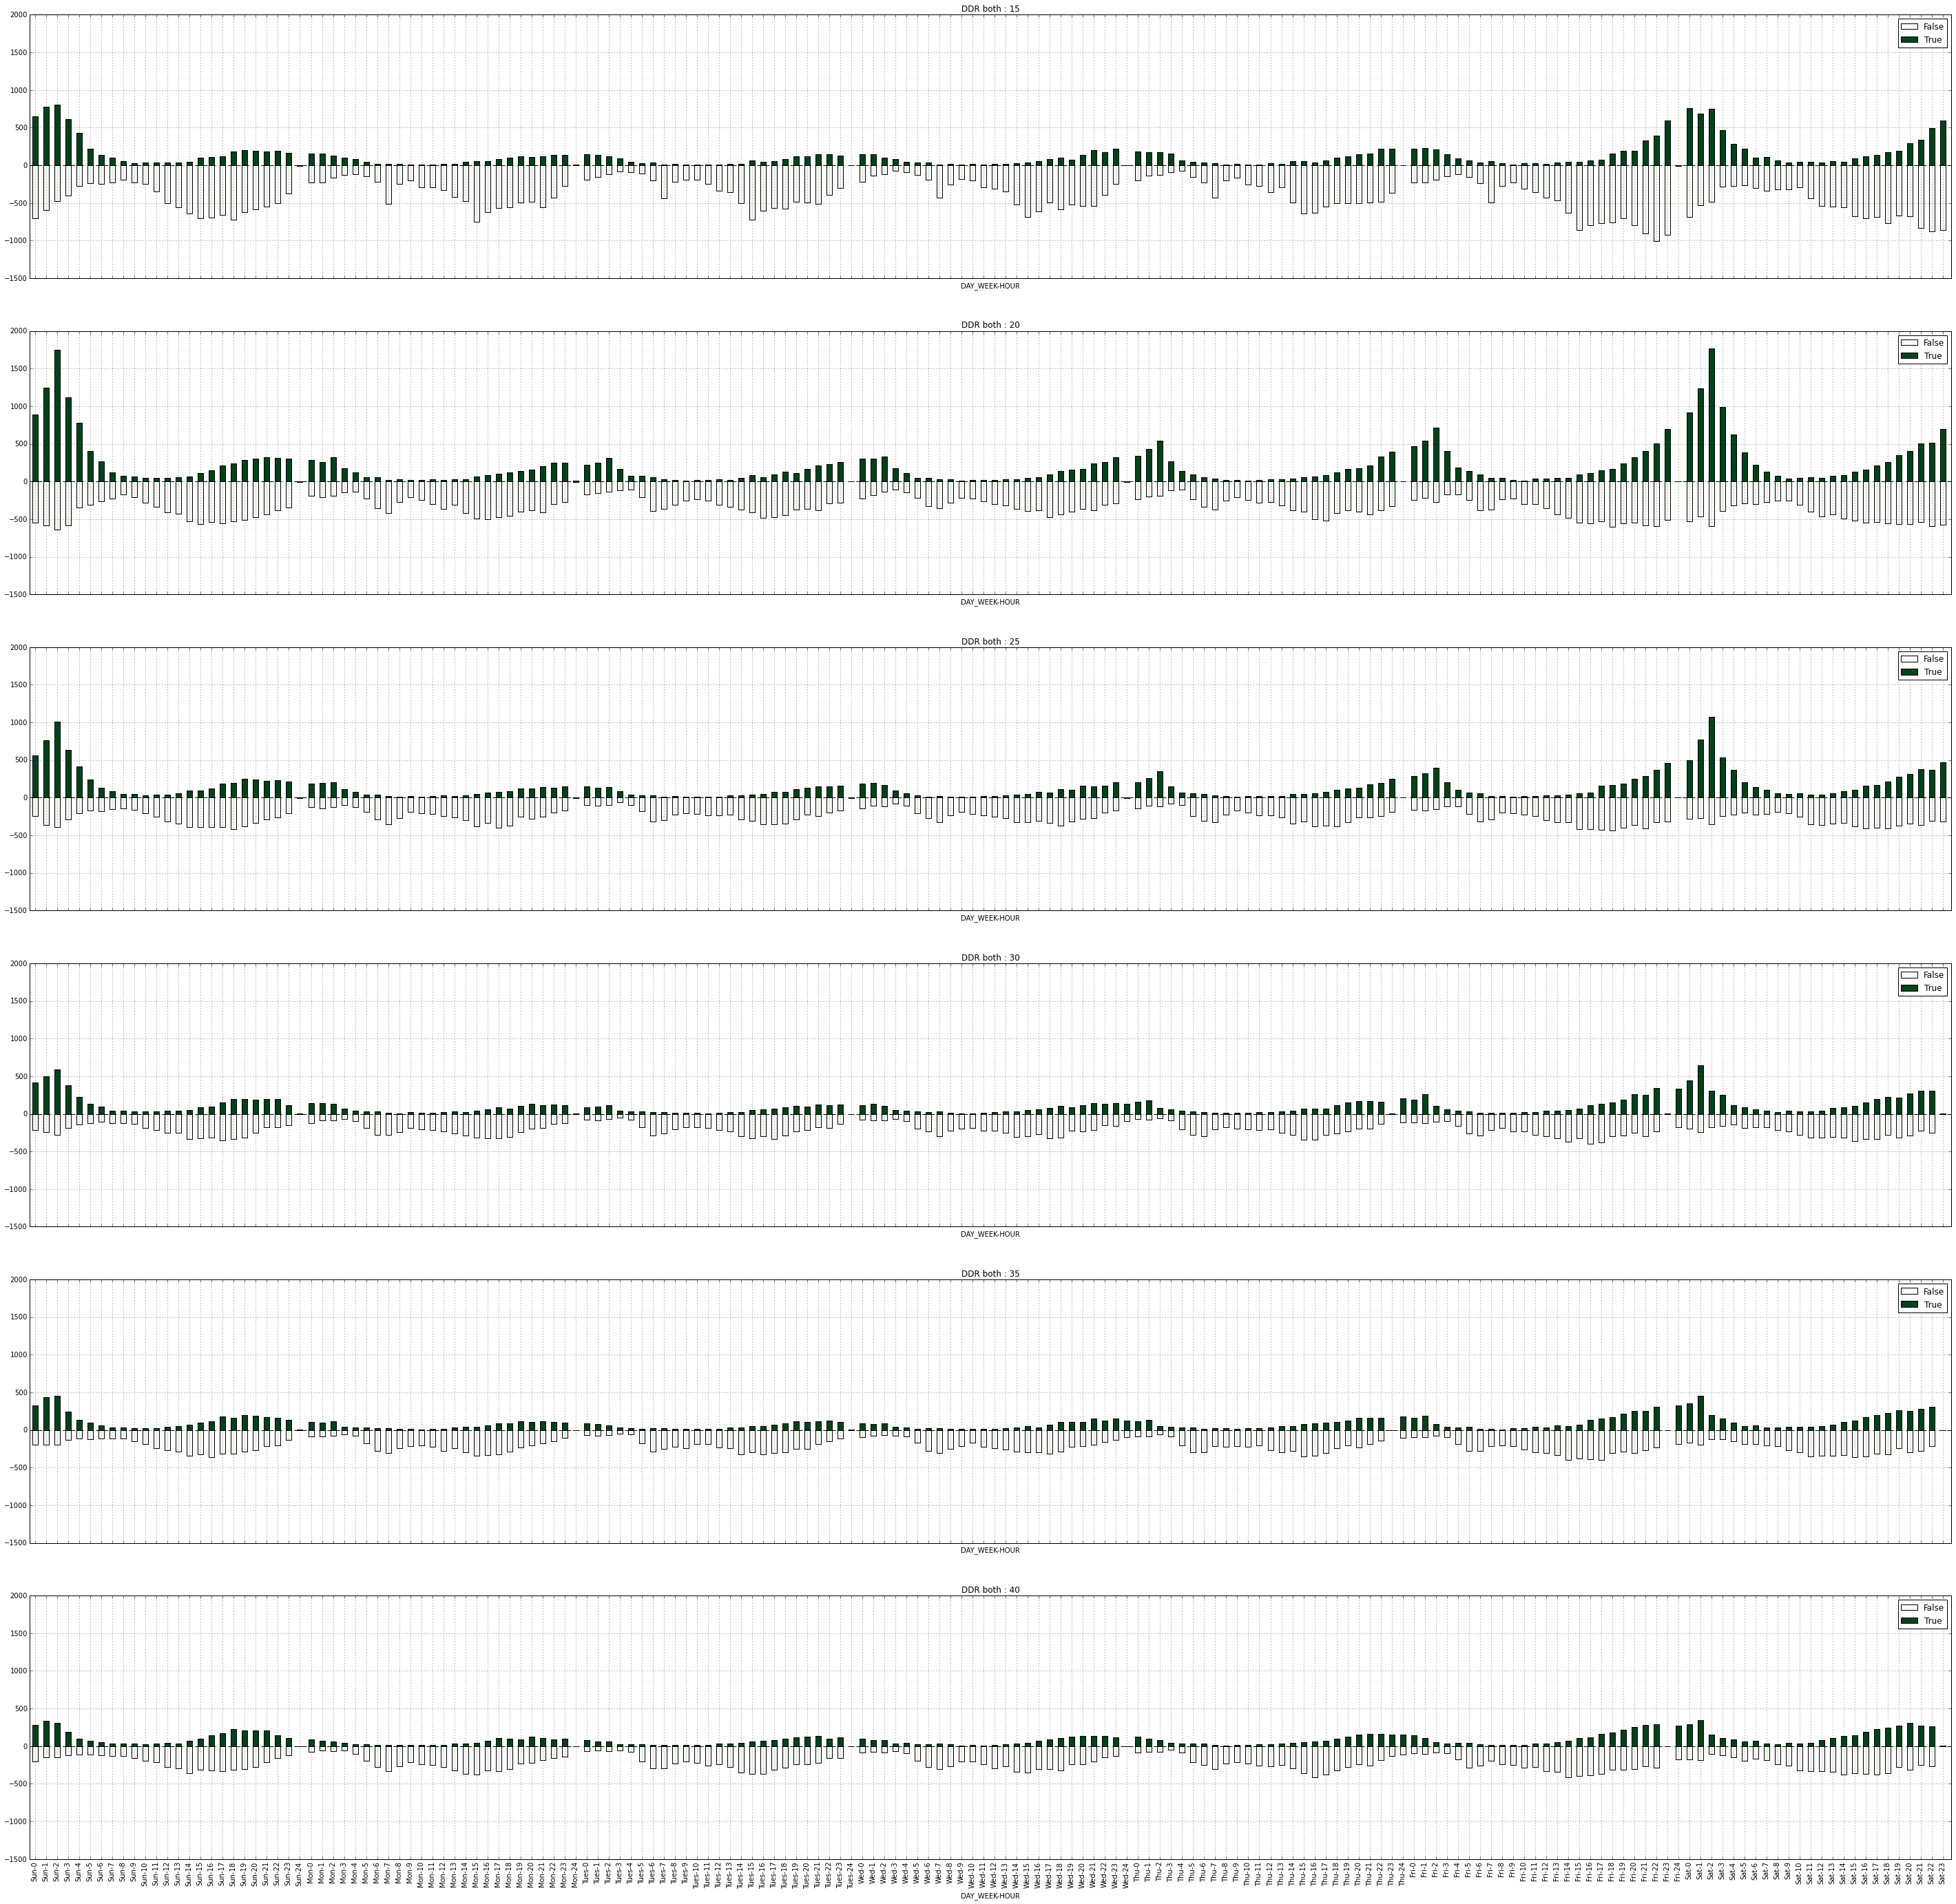

In [50]:
# what times of the day are different aged drivers crashing?
# now plot the DDR/no groups about the y-axis

interesting_charts = slice(3, 9)
n_charts = len(age_fives_labels[interesting_charts])
fig, axs = plt.subplots(n_charts, 1, sharex=True, sharey=True)

for i, age_group in enumerate(age_fives_labels[interesting_charts]):
    
    # unstack and make the mirror
    test0 = acc_per_df[(acc_per_df.AGE_GROUP == age_group)].groupby(['DAY_WEEK-HOUR', 'DRUNK_DR'])['DAY_WEEK-HOUR'].count().unstack('DRUNK_DR')
    # this should be 'False'.. couldn't select it normally though
    # test0.columns[0] <- check that = 'False'
    test0[test0.columns[0]] = -1*test0[test0.columns[0]]
    test0.ix[:,0]
    
    # plot
    fig.set_size_inches(50,n_charts*8)
    ax0 = test0.plot(kind='bar', ax=axs[i],title='DDR both Accident Counts : ' + age_group,
                     stacked=True, colormap='Greens')
    ax0.set_xticklabels(day_week_hr_labels)
    ax0.legend(loc='upper right')
plt.show()


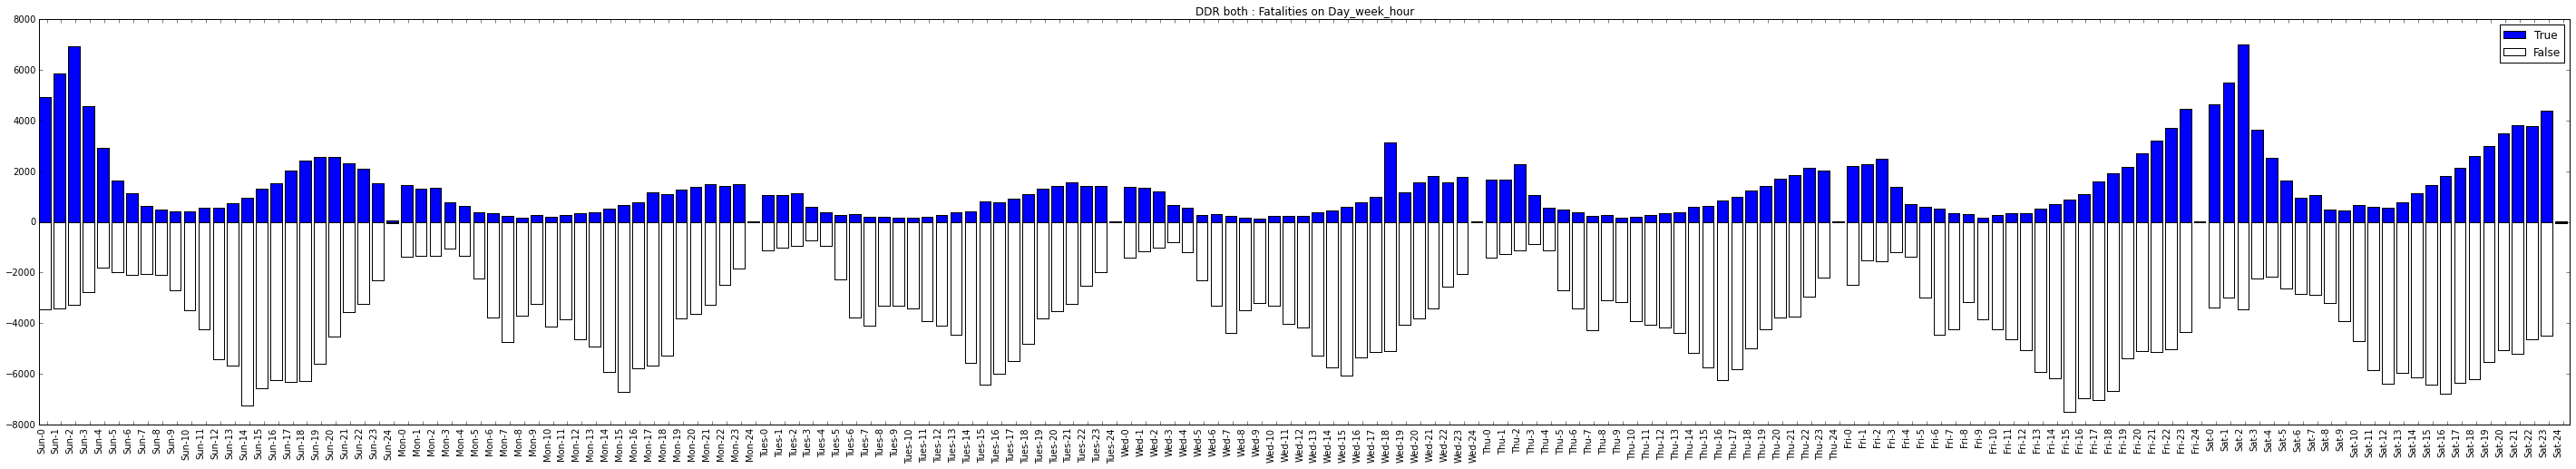

In [111]:
# what times of the day are different aged drivers crashing, w/fatalities?
# plot the DDR/no groups about the y-axis
# step 1 (without age groups)

daywkhr_ddr_group = acc_per_df.groupby(['DAY_WEEK-HOUR', 'DRUNK_DR'])
ddr_daywkhr_dict = {}
ddr_daywkhr_dict[True] = []
ddr_daywkhr_dict[False] = []
for is_ddr in [True, False]:
    # see how daywkhr_labels were made to get 7*25 (7 days, 0-24 valued)
    for daywkhr in range(1*25, 8*25):
        if (daywkhr, is_ddr) in daywkhr_ddr_group.groups.keys():
            ddr_daywkhr_dict[is_ddr].append(acc_per_df.ix[daywkhr_ddr_group.groups[daywkhr, is_ddr]]['FATALS'].sum())
        else:
            ddr_daywkhr_dict[is_ddr].append(0)
ddr_daywkhr_dict
        
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(50,8)
bins = np.arange(len(ddr_daywkhr_dict[True]))
bars1 = axs.bar(bins, ddr_daywkhr_dict[True])
axs.set_title('DDR both : Fatalities on Day_week_hour')
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in bars1]
plt.xticks(xticks_pos, day_week_hr_labels,  ha='right', rotation=90)
plt.xlim([0,bins.size])
bars2 = axs.bar(bins, -1*np.array(ddr_daywkhr_dict[False]), color='w')
axs.legend((bars1[0], bars2[0]), ('True', 'False'))
plt.show()


In [115]:
# what times of the day are different aged drivers crashing, w/fatalities?
# plot the DDR/no groups about the y-axis

from collections import defaultdict

# TODO need to cut out unknowns not matching age groups .... match how 'AGE_GROUP' was made ???
daywkhr_agegr_ddr_group = acc_per_df.groupby(['DAY_WEEK-HOUR', 'AGE_GROUP', 'DRUNK_DR'])
#
ddr_daywkhr_agegr_dict = defaultdict(list)
# only examine the 'interesting_charts'
for _age_group in age_fives_labels[interesting_charts]:
    for is_ddr in [True, False]:
        # see how daywkhr_labels were made to get 7*25 (7 days, 0-24 valued)
        for daywkhr in range(1*25, 8*25):
            if (daywkhr, is_ddr) in daywkhr_ddr_group.groups.keys():
                ddr_daywkhr_agegr_dict[(_age_group, is_ddr)].append(
                    acc_per_df.ix[daywkhr_agegr_ddr_group.groups[daywkhr, _age_group, is_ddr]]['FATALS'].sum())
            else:
                ddr_daywkhr_agegr_dict[(_age_group, is_ddr)].append(0)
ddr_daywkhr_agegr_dict

fig, axs = plt.subplots(n_charts, 1, sharex=True, sharey=True)
for i, age_group in enumerate(age_fives_labels[interesting_charts]):
    
    # plot
    fig.set_size_inches(50,n_charts*8)
        
    bins = np.arange(len(ddr_daywkhr_agegr_dict[(age_group, True)]))
    bars1 = axs[i].bar(bins, ddr_daywkhr_agegr_dict[(age_group, True)])
    axs[i].set_title('DDR both : Fatalities on Day_week_hour : for Age group ' + age_group)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in bars1]
    plt.xticks(xticks_pos, day_week_hr_labels,  ha='right', rotation=90)
    plt.xlim([0,bins.size])
    bars2 = axs[i].bar(bins, -1*np.array(ddr_daywkhr_dict[False]), color='w')
    axs[i].legend((bars1[0], bars2[0]), ('True', 'False'))
    
plt.show()




KeyError: (99, '15', True)

In [103]:
len(day_week_hr_labels)

175

In [3]:
acc_per_df = pd.merge(acc_df, per_df, on='ID')

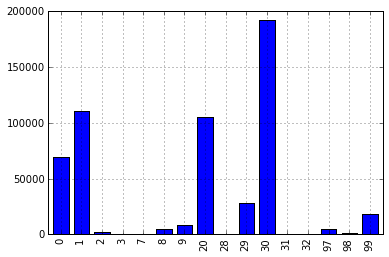

In [13]:
acc_per_df[acc_per_df.DRUNK_DR == False]['AIR_BAG'].value_counts().sort_index().plot(kind='bar')
# acc_per_df[acc_per_df.DRUNK_DR == True]['AIR_BAG'].value_counts().sort_index().plot(kind='bar')
# some strange 97, 98 (they meant 99?)

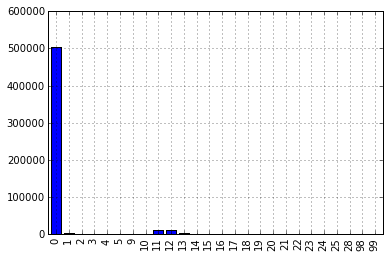

In [8]:
# Location (of pedestrian)
acc_per_df[acc_per_df.DRUNK_DR == False]['LOCATION'].value_counts().sort_index().plot(kind='bar')
# acc_per_df[acc_per_df.DRUNK_DR == True]['LOCATION'].value_counts().sort_index().plot(kind='bar')
# Drunk driving -> slightly more likely for 0 than 11/12

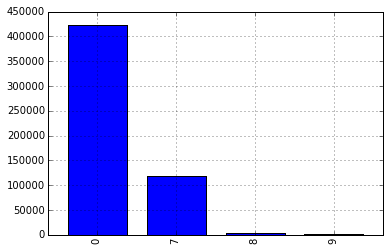

In [46]:
acc_per_df[acc_per_df.DRUNK_DR == False]['DOA'].value_counts().sort_index().plot(kind='bar')
# Drunk driving -> more likely to have 7 (died at scene)

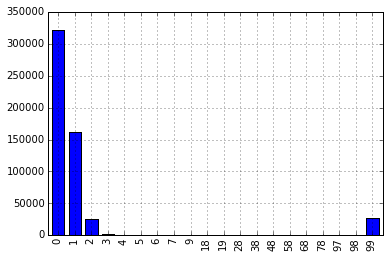

In [43]:
acc_per_df[acc_per_df.DRUNK_DR == False]['RACE'].value_counts().sort_index().plot(kind='bar')
# Drunk driving -> more likely to have 1 recorded

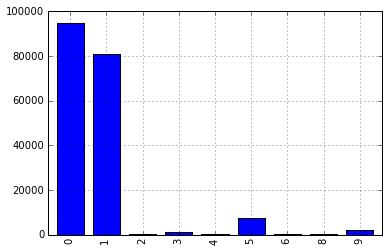

In [39]:
acc_per_df[acc_per_df.DRUNK_DR == True]['HOSPITAL'].value_counts().sort_index().plot(kind='bar')
# acc_per_df[acc_per_df.DRUNK_DR == False]['HOSPITAL'].value_counts().sort_index().plot(kind='bar')
# Drunk driving -> more likely to not involve hospital
# and, why are there responses in 2-8 range?? only 9 is unk

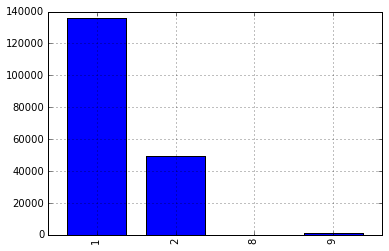

In [28]:
acc_per_df[acc_per_df.DRUNK_DR == True]['SEX'].value_counts().sort_index().plot(kind='bar')
# as expected, males more likely to be involved

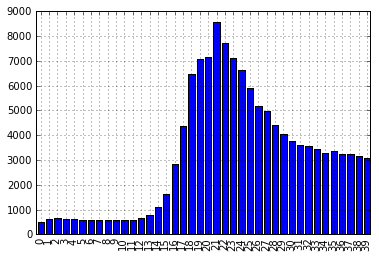

In [13]:
# experiments with age

acc_per_df[acc_per_df.DRUNK_DR == True]['AGE'].value_counts().sort_index().plot(kind='bar', xlim=[0,40])
# peak at ~driving age, vs ~drinking age
# also note the 999's, which should just be 99's

# labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
# acc_per_df['AGE_GROUP'] = pd.cut(acc_per_df.AGE, range(0, 101, 10), right=False, labels=labels)
# acc_per_df[acc_per_df.DRUNK_DR == False]['AGE_GROUP'].value_counts().sort_index().plot(kind='bar')

'\nacc_per_df[acc_per_df.REST_USE == 96].info()\nEven though 96 is not defined, there are 5480 such entries\n'

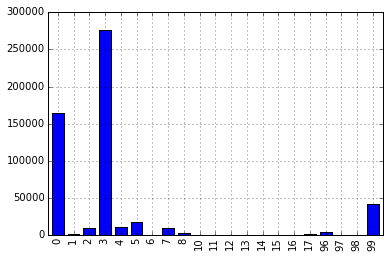

In [16]:
# experiments with seat belt/other restraint usage

acc_per_df[acc_per_df.DRUNK_DR == False]['REST_USE'].value_counts().sort_index().plot(kind='bar')
# acc_per_df[acc_per_df.REST_USE == 96].info()
"""
acc_per_df[acc_per_df.REST_USE == 96].info()
Even though 96 is not defined, there are 5480 such entries
- DRUNK_DR has proportionally more instances of 0 ~ as expected
"""

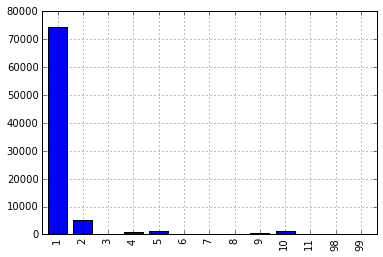

In [19]:
acc_df[(acc_df.DRUNK_DR == True)]['WEATHER'].value_counts().sort_index().plot(kind='bar')

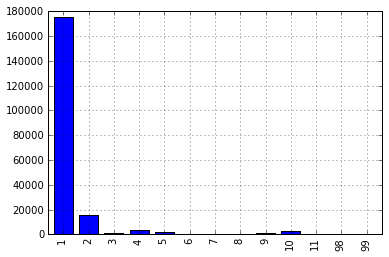

In [20]:
acc_df[(acc_df.DRUNK_DR == False)]['WEATHER'].value_counts().sort_index().plot(kind='bar')

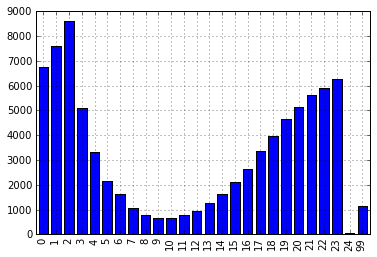

In [11]:
# acc_df.head()
# acc_df['HOUR'].value_counts().sort_index().plot(kind='bar')
acc_df[(acc_df.DRUNK_DR == True)]['HOUR'].value_counts().sort_index().plot(kind='bar')

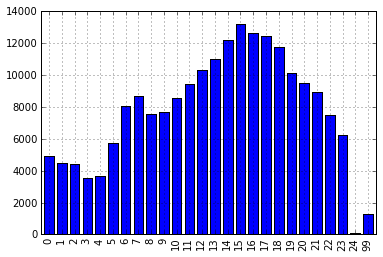

In [12]:
acc_df[(acc_df.DRUNK_DR == False)]['HOUR'].value_counts().sort_index().plot(kind='bar')
# morning rush peak at 7, evening commute at 3/4, then dies down

In [8]:
# Let's explore the data a little bit.
daywk_group = acc_df.groupby('DAY_WEEK')
daywks = list(daywk_group.groups.keys())
fatals = np.zeros(len(daywks))
for i, daywk in enumerate(daywks):
    fatals[i] = acc_df.ix[daywk_group.groups[daywk]][(acc_df.DRUNK_DR == True)]['FATALS'].sum()
#     fatals[i] = acc_df.ix[daywk_group.groups[daywk]][(acc_df.DRUNK_DR == False)]['FATALS'].sum()

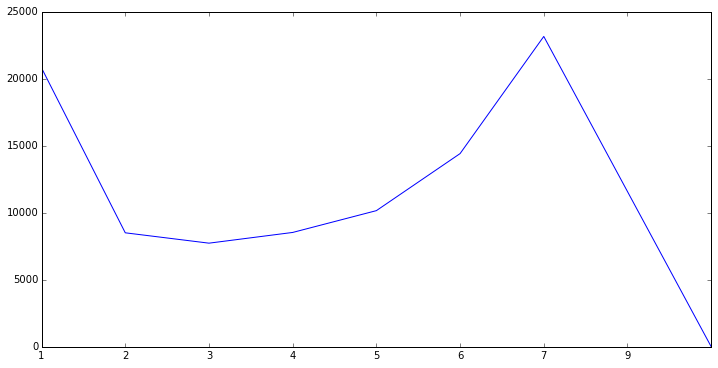

In [9]:
fig = plt.figure()
fig.set_size_inches(12,6)

ax = fig.add_subplot(111)
ax.plot(daywks, fatals)
labels = ax.set_xticklabels([str(daywk) for daywk in daywks])
# no DDR- roughly uniform, slight uptick towards fri/sat (weekend effect)
# DDR - large increase towards weekend, and sharp drop to mon

In [30]:
acc_veh_df = pd.merge(acc_df, veh_df, on='ID')

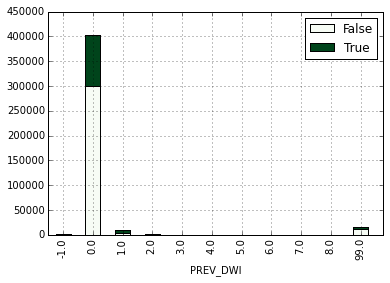

In [59]:
# PREV_DWI
from matplotlib import cm
# regular vis way
# acc_veh_df[acc_veh_df.DRUNK_DR == False]['PREV_DWI'].value_counts().sort_index().plot(kind='bar')
# acc_veh_df[acc_veh_df.DRUNK_DR == True]['PREV_DWI'].value_counts().sort_index().plot(kind='bar')
# Drunk driving -> slightly more likely for 1,2

# stacked vis
test0 = acc_veh_df.groupby(['PREV_DWI', 'DRUNK_DR'])['PREV_DWI'].count().unstack('DRUNK_DR')
ax0 = test0.plot(kind='bar', stacked=True, colormap='Greens')
ax0.legend(loc='upper right')
# , ylim=[90000, 350000]

# 'apparently dupe ids'
# acc_veh_df[['ID', 'VEH_NO']].head(10)
# -> some IDs look duplicated, but it is due to dif vehicles in same accident

In [ ]:
# speed limit grouping
# ~SP_LIMIT def given, but not in any table - also try getting this from maps?
daywk_group = acc_df.groupby('DAY_WEEK')
daywks = list(daywk_group.groups.keys())
fatals = np.zeros(len(daywks))
for i, daywk in enumerate(daywks):
#     fatals[i] = acc_df.ix[daywk_group.groups[daywk]][(acc_df.DRUNK_DR == True)]['FATALS'].sum()
    fatals[i] = acc_df.ix[daywk_group.groups[daywk]][(acc_df.DRUNK_DR == False)]['FATALS'].sum()

In [28]:
veh_df['SP_LIMIT'].size

KeyError: u'no item named SP_LIMIT'

In [64]:
state_group = acc_df.groupby('STATE')
states = list(state_group.groups.keys())
fatals = np.zeros(len(states))
for i, state in enumerate(states):
    fatals[i] = acc_df.ix[state_group.groups[state]]['FATALS'].sum()
fatals.size

51

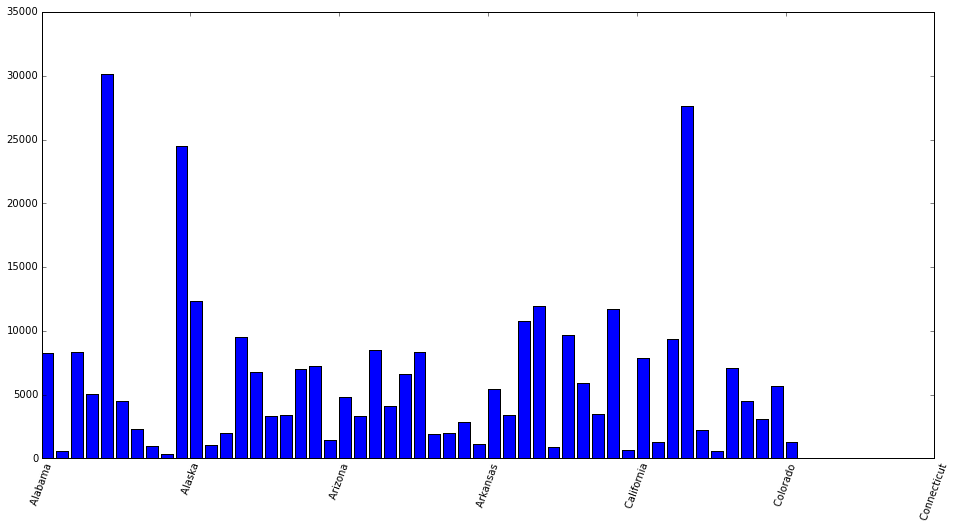

In [77]:
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
width = 0.1

states = ["Alabama ","Alaska ","Arizona ","Arkansas ",
"California ",
"Colorado ",
"Connecticut ", 
"District of Columbia ",
"Delaware ",
"Florida ",
"Georgia ",
"Hawaii ",
"Idaho ",
"Illinois ",
"Indiana ",
"Iowa ",
"Kansas ",
"Kentucky ",
"Louisiana ",
"Maine ",
"Maryland ",
"Massachusetts ",
"Michigan ",
"Minnesota ",
"Mississippi", 
"Missouri ",
"Montana ",
"Nebraska ",
"Nevada ",
"New Hampshire ", 
"New Jersey ",
"New Mexico ",
"New York ",
"North Carolina ","North Dakota ","Ohio ","Oklahoma ",
"Oregon ","Pennsylvania ","Rhode Island ","South Carolina ",
"South Dakota ", "Tennessee ","Texas ","Utah ","Vermont ",
"Virginia ","Washington ","West Virginia ", "Wisconsin ", "Wyoming "]

len(states)
ax.bar(np.arange(len(states)), fatals)
# ticks = ax.set_xticks(np.arange(len(states)), states)
ax.set_xticklabels(states, rotation=70)
# labels = ax.set_xticklabels([str(state) for state in states], rotation=70)

In [57]:
fatals

array([  8302.,    610.,   8315.,   5078.,  30156.,   4467.,   2323.,
         1012.,    326.,  24485.,  12334.,   1043.,   2014.,   9555.,
         6785.,   3339.,   3441.,   7030.,   7271.,   1416.,   4809.,
         3293.,   8538.,   4072.,   6622.,   8366.,   1922.,   1969.,
         2818.,   1096.,   5428.,   3421.,  10805.,  11964.,    899.,
         9667.,   5934.,   3498.,  11747.,    639.,   7855.,   1315.,
         9358.,  27656.,   2246.,    611.,   7124.,   4493.,   3070.,
         5673.,   1292.])